<a href="https://colab.research.google.com/github/hungrypro7/Shine_Coding/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 생존자 예측

타이타닉 생존자 예측을 위한 데이터 분석을 진행하겠습니다. 먼저 분석을 위해서 훈련용(train.csv) 데이터를 불러 오겠습니다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 훈련용 데이터 불러오기
train = pd.read_csv("https://raw.githubusercontent.com/developer-sdk/kaggle-python-beginner/master/datas/kaggle-titanic/train.csv")
# 앞의 5개만 가져옵니다
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 결측치 확인
데이터의 이상 여부를 확인하기 위해 먼저 결측치를 확인하습니다. 결측치, 이상치는 분석 결과를 왜곡 시킬 수 있기 때문에 적절한 값으로 채워주거나, 분석 대상에서 제외해야 합니다.

In [2]:
# 데이터 프레임의 null 값의 개수를 세어 줌
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 전처리

|   기존 칼럼     	|   신규 칼럼        	|   설명                                                                                 	|
|-----------------	|--------------------	|----------------------------------------------------------------------------------------	|
|   Sex           	|   Sex              	|   성별. female -> 0, male -> 1로 변환                                                  	|
|   Embarked      	|   Embarked         	|   탑승항. C -> 0, Q -> 1, S -> 2로 변환                                                	|
|   Name          	|   Title            	|   이름에서 호칭을 추출. Master -> 0, Miss -> 1, Mr -> 2, Mrs -> 3, Other -> 4로 변환   	|
|   Age           	|   AgeCategory      	|   나이를 qcut으로 8개의 구간으로 분리하여 카테고리화. 결측치는 호칭의 평균값으로 채움  	|
|   Cabin         	|   CabinCategory    	|   방번호를 첫 글자만 따서 카테고리화. 결측치는 N으로 채움                              	|
|   Fare          	|   FareCategory     	|   운임을 8개의 구간으로 분리하여 카테고리화. 결측치는 0으로 채움                       	|
|   SibSp, Parch  	|   Family, IsAlone  	|   가족으로 합침. 혼자 탑승한 고객 정보 추출                                            	|
|   Ticket        	|   TicketCategory   	|   티켓 번호의 첫 번째 번호만 추출하여 카테고리화                                       	|

In [3]:
def feature_engineering(df):
    # Sex
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

    # Embarked
    df.Embarked.fillna('S', inplace=True)
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

    # Title
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Countess', 'Don','Dona', 'Dr', 'Jonkheer', 'Lady','Major', 'Rev', 'Sir'], 'Other')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs':3, 'Other':4})

    # Age
    meanAge = df[['Title', 'Age']].groupby(['Title']).mean()
    for index, row in meanAge.iterrows():
        nullIndex = df[(df.Title == index) & (df.Age.isnull())].index
        df.loc[nullIndex, 'Age'] = row[0]

    df['AgeCategory'] = pd.qcut(df.Age, 8, labels=range(1, 9))
    df.AgeCategory = df.AgeCategory.astype(int)

    # Cabin
    df.Cabin.fillna('N', inplace=True)
    df["CabinCategory"] = df["Cabin"].str.slice(start=0, stop=1)
    df["CabinCategory"] = df['CabinCategory'].map({ "N": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8 })

    # Fare
    df.Fare.fillna(0, inplace=True)
    df['FareCategory'] = pd.qcut(df.Fare, 8, labels=range(1, 9))
    df.FareCategory = df.FareCategory.astype(int)

    # SibSp, Parch
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df.loc[df["Family"] > 4, "Family"] = 5

    df['IsAlone'] = 1
    df.loc[df['Family'] > 1, 'IsAlone'] = 0

    # Ticket
    df['TicketCategory'] = df.Ticket.str.split()
    df['TicketCategory'] = [i[-1][0] for i in df['TicketCategory']]
    df['TicketCategory'] = df['TicketCategory'].replace(['8', '9', 'L'], '8')
    df['TicketCategory'] = pd.factorize(df['TicketCategory'])[0] + 1

    df.drop(['PassengerId', 'Ticket', 'Cabin', 'Fare', 'Name', 'Age', 'SibSp', 'Parch'], axis=1, inplace=True)

    return df

train = feature_engineering(train)

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int64
 3   Embarked        891 non-null    int64
 4   Title           891 non-null    int64
 5   AgeCategory     891 non-null    int64
 6   CabinCategory   891 non-null    int64
 7   FareCategory    891 non-null    int64
 8   Family          891 non-null    int64
 9   IsAlone         891 non-null    int64
 10  TicketCategory  891 non-null    int64
dtypes: int64(11)
memory usage: 76.7 KB


전처리가 끝나면 분석에 사용할 데이터만 남아 있고, 나머지 데이터는 없어진 것을 확인할 수 있습니다.

## 분석용 차트 생성 함수
생존 여부(Survived)와 각 칼럼 간의 관계를 파이 차트로 분석하기 위해 공통 함수를 아래와 같이 구현하였습니다.

show_pie_chart  
survived_crosstab, pie_chart 함수를 이용하여 파이차트 생성

survived_crosstab  
col_name과 Survived 간의 교차 도표 생성
생존 여부를 보기 편하게 문자로 변환

pie_chart  
파이 차트 생성

In [4]:
def show_pie_chart(df, col_name):
    colname_survived = survived_crosstab(train, col_name)
    pie_chart(colname_survived)
    return colname_survived

def survived_crosstab(df, col_name):
    '''col_name과 Survived간의 교차도표 생성'''
    feature_survived = pd.crosstab(df[col_name], df['Survived'])
    feature_survived.columns = feature_survived.columns.map({0:"Dead", 1:"Alive"})
    return feature_survived

def pie_chart(feature_survived):
    '''
    pie_chart 생성
    pcol, prow = 차트를 출력할 개수. pcol * prow 만큼의 차트 출력
    '''
    frows, fcols = feature_survived.shape
    pcol = 3
    prow = (frows//pcol + frows%pcol)
    plot_height = prow * 2.5
    plt.figure(figsize=(8, plot_height))

    for row in range(0, frows):
        plt.subplot(prow, pcol, row+1)

        index_name = feature_survived.index[row]
        plt.pie(feature_survived.loc[index_name], labels=feature_survived.loc[index_name].index, autopct='%1.1f%%')
        plt.title("{0}' survived".format(index_name))

    plt.show()


### Sex
성별과 생존률의 관계를 확인해 봅시다

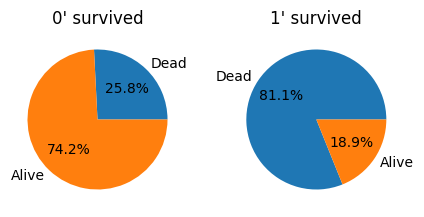

Survived,Dead,Alive
Sex,,
0,81,233
1,468,109


In [5]:
c = show_pie_chart(train, 'Sex')
# 위에서 여자는 0, 남자는 1로 바꾸었습니다
c

남성에 비해 여성의 생존률이 높은 것을 확인할 수 있습니다.

### Fare
운임과 생존률의 관계를 알아 보겠습니다. 운임의 결측치는 0으로 채우고 qcut을 이용하여 8개의 구간으로 분리하여 카테고리로 만들어 줍니다.

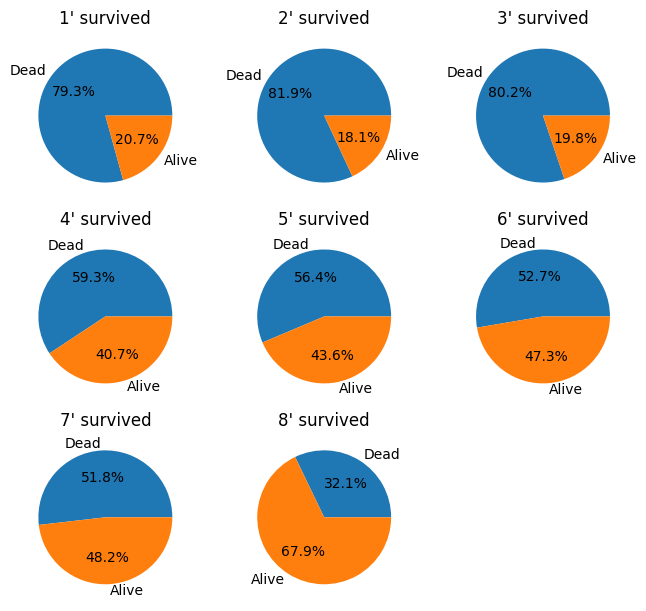

Survived,Dead,Alive
FareCategory,,
1,111,29
2,68,15
3,89,22
4,67,46
5,62,48
6,59,53
7,57,53
8,36,76


In [6]:
c = show_pie_chart(train, 'FareCategory')
# 위에서 운임을 8개의 구간으로 분리하여 카테고리화(8이 가장 높은 운임)
c

운임이 높을 수록 생존률이 높아지는 것을 알 수 있습니다.

## 문제1
나이와 생존 확률 그래프를 그려봅시다

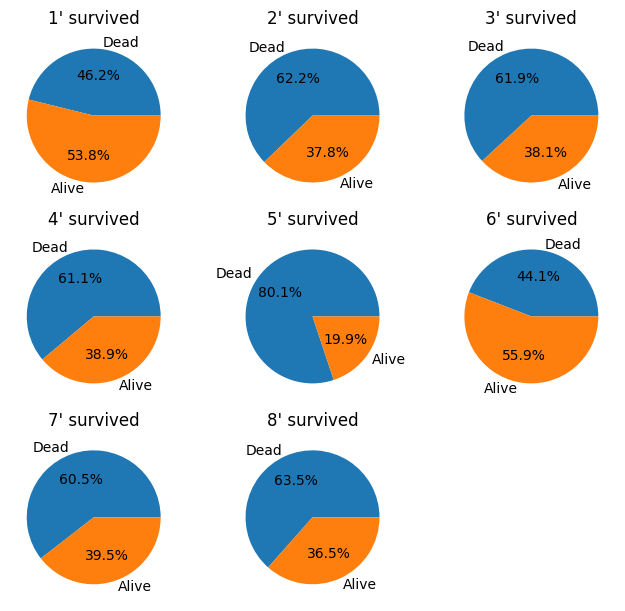

Survived,Dead,Alive
AgeCategory,,
1,54,63
2,79,48
3,60,37
4,66,42
5,125,31
6,30,38
7,69,45
8,66,38


In [8]:
c = show_pie_chart(train, 'AgeCategory')
# 위에서 운임을 8개의 구간으로 분리하여 카테고리화(8이 가장 높은 운임)
c

# 머신러닝

전처리가 끝난 데이터에 예측 모델 알고리즘을 적용하는 방법을 알아보겠습니다. 지도 학습에 사용하는 몇 가지 알고리즘을 적용하기 위해 ml_fit 함수를 선언하고, 예측 모델을 기본 파라미터로 생성하여 생존률을 알아보겠습니다.

In [9]:
# 지도학습 모델 import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 학습용 데이터와 시험용 데이터를 분리합니다
# 시험용 데이터를 공부한뒤 시험을 보면 안되겠죠?
data = train.drop('Survived', axis=1).values  # 학습용
target = train['Survived'].values             # 시험용
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

# 모델 적용 함수
def ml_fit(model):
    model.fit(x_train, y_train)
    prediction = model.predict(x_valid)
    accuracy = accuracy_score(prediction, y_valid)
    print(model)
    print(f'총 {y_valid.shape[0]}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')
    return model

# 기본 설정으로만 테스트
model = ml_fit(RandomForestClassifier(n_estimators=100))
model = ml_fit(LogisticRegression(solver='lbfgs'))


RandomForestClassifier()
총 357명 중 81.232% 정확도로 생존을 맞춤
LogisticRegression()
총 357명 중 79.832% 정확도로 생존을 맞춤
